In [64]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import json
import os
import numpy as np
import tensorflow as tf 
from sklearn.preprocessing import MinMaxScaler
import kagglehub 
import urllib
from dotenv import load_dotenv

In [65]:
data = pd.read_csv(r'/Users/evanlynch/Developer/notebook/data/stock_market_data-AAL.csv')

In [66]:
load_dotenv()

# Alpha Vantage API Key
key = os.getenv("API_KEY")

# Import only stocks data from Kaggle dataset
path = kagglehub.dataset_download(
    "borismarjanovic/price-volume-data-for-all-us-stocks-etfs")

print("Path to dataset files:", path)

Path to dataset files: /Users/evanlynch/.cache/kagglehub/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/versions/3


In [67]:
data_source = 'alphavantage' # alphavantage or kaggle

if data_source == 'alphavantage':
    # ====================== Loading Data from Alpha Vantage ==================================

    api_key = '61QSG0UFUU2IQB41'

    # American Airlines stock market prices
    ticker = "AAL"

    # JSON file with all the stock market data for AAL from the last 20 years
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

    # Save data to this file
    file_to_save = 'stock_market_data-%s.csv'%ticker

    # If you haven't already saved data,
    # Go ahead and grab the data from the url
    # And store date, low, high, volume, close, open values to a Pandas DataFrame
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)        
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)

else:

    # ====================== Loading Data from Kaggle ==================================
    # You will be using HP's data. Feel free to experiment with other data.
    # But while doing so, be careful to have a large enough dataset and also pay attention to the data normalization
    df = pd.read_csv(os.path.join('Stocks','hpq.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
    print('Loaded data from the Kaggle repository')


File already exists. Loading data from CSV


In [68]:
# Sort DataFrame by date
df = df.sort_values('Date')

# Double check the result
df.head()

,Unnamed: 0,Date,Low,High,Close,Open
4969,0,2005-09-27,19.10,21.40,19.30,21.05
4968,1,2005-09-28,19.20,20.53,20.50,19.30
4967,2,2005-09-29,20.10,20.58,20.21,20.40
4966,3,2005-09-30,20.18,21.05,21.01,20.26
4965,4,2005-10-03,20.90,21.75,21.50,20.90


In [69]:
# Number of date instances
df.shape[0]

4970

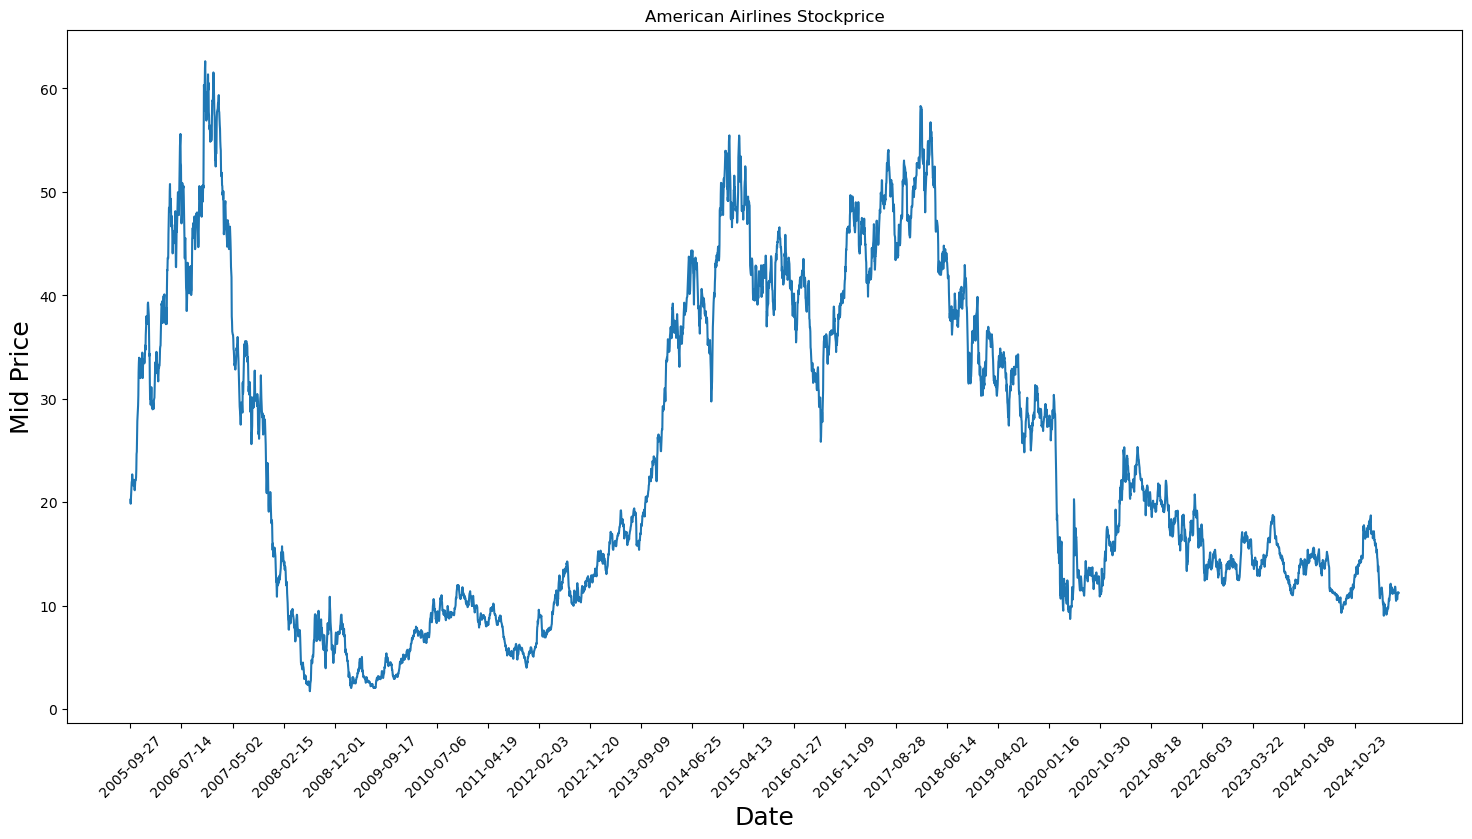

In [70]:
plt.figure(figsize = (18,9))
plt.title('American Airlines Stockprice') 
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0) # mid prices
plt.xticks(range(0,df.shape[0],200),df['Date'].loc[::200],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

### Mid Price

* The Mid Price is the exact mid-point between the quoted Bid Price and Ask Price for a security. It can differ considerably from the Last Price as the last trade may have been higher (at the ask) or lower (at the bid).

* While you cannot trade at the Mid Price many investors treat it as a proxy for the actual price of a security. For some investors it is a more popular quote than the Last Price.

In [71]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'High'].to_numpy()
low_prices = df.loc[:,'Low'].to_numpy()
mid_prices = (high_prices + low_prices)/2.0

In [73]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(mid_prices, train_size=0.5, random_state=42)

In [84]:
train

array([0.37851721, 0.61300835, 0.74308773, ..., 0.74741415, 0.34919159,
       0.11487678])

### MinMaxScaler

A way to normalize the input features/variables is the Min-Max scaler. By doing so, all features will be transformed into the range [0,1] meaning that the minimum and maximum value of a feature/variable is going to be 0 and 1, respectively.

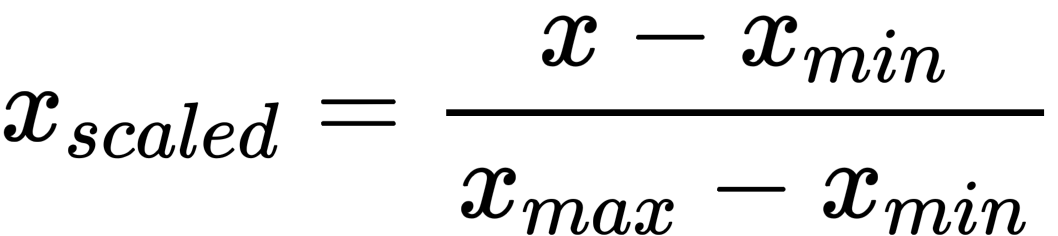

Variables that are measured at different scales do not contribute equally to the model fitting & model learned function and might end up creating a bias. Thus, to deal with this potential problem feature-wise normalization such as MinMax Scaling is usually used prior to model fitting.



In [74]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train.reshape(-1,1)
test_data = test.reshape(-1,1)


## `MinMaxScaler`

* `MinMaxScaler` expects data to be in a 2D array
* train & test = 1d arrays
* `.rehape(-1, 1)` - reshapes 1D array `(n_samples)` into 2D array `(n_samples, 1)`

In [75]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 500

# Check if we have enough data
if len(train_data) < smoothing_window_size:
    raise ValueError(f"Not enough training data. Need at least {smoothing_window_size} samples")

# Normalize data in windows
for di in range(0, len(train_data), smoothing_window_size):
    end_idx = min(di + smoothing_window_size, len(train_data))
    scaler.fit(train_data[di:end_idx,:])
    train_data[di:end_idx,:] = scaler.transform(train_data[di:end_idx,:])

# No need for additional normalization of remaining data since we're using
# range(0, len(train_data), smoothing_window_size) which handles all data

In [76]:
# Reshape train data
train_data = train_data.reshape(-1)

# Reshape test data to 2D array for scaling
test_data = test_data.reshape(-1, 1)

# Fit and transform test data
scaler.fit(test_data)
test_data = scaler.transform(test_data).reshape(-1)

## Exponential Moving Average (EMA) Smoothing

* Used for smoothing time series using the exponential window function
* EMA assigns exponentially decreasing weights over time
* Work as low-pass-filters to remove high-frequency noise in the data

The raw data sequence is often represented by ${x_{t}}$ beginning at time ${t = 0}$ and the output of the exponential smoothing algorithm is commonly written as ${s_{t}}$, which may be regarded as a best estimate of what the next value of ${x}$ will be. When the sequence of observations begins at time ${t=0}$, the simplest form of exponential smoothing is given by the following formulas:

* $s_0 = x_0$

* $s_{t}=\alpha x_{t}+(1-\alpha )s_{t-1}=s_{t-1}+\alpha (x_{t}-s_{t-1})$

where $α$ is the smoothing factor, and $0 < α < 1$ . If $s_t − 1$ is substituted into $s_t$ continuously so that the formula of $s_t$ is fully expressed in terms of ${x_t}$, then exponentially decaying weighting factors on each raw data $x_{t}$ is revealed, showing how exponential smoothing is named.

* $α$ = `gamma`
* ${x_t}$ = `train_data`



In [77]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.7

# Use the actual length of train_data instead of hardcoded value
for ti in range(len(train_data)):
    EMA = gamma*train_data[ti] + (1-gamma)*EMA
    train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

## One Step Ahead Prediction via Averaging

A mathematical model which takes in a set of historical values and uses them to predict a future one.

* The difference between the prediction and the actual value is the error - this is then used to adjust our model.

* In order to test how effective it is, we need to test it against all of our historical data - what would the error have been if we had used this model all along? To do this, we go back to the start of our historical data and feed it in one at a time. E.g. the error for the 2nd value is calculated by giving the model only the 1st value and then finding the difference between it's prediction and the actual measured 2nd value. Similarly, the error for, say, the 10th would be found by giving the model the 1st-9th values and then comparing the prediction to the actual 10th value. 


### Variance 

* If we do this for our whole dataset, we now have a set of error values for each of our measured values (apart from the first). Because we've adjusted our model already, we would expect the average of these error values to be 0 - if we were, on average, predicting values too high or too low, that would indicate that we haven't been adjusting the model properly. Since our average error value ought to be 0, the way we measure the effectiveness of our model is by the average of how far off our predictions were - this is the variance




In [78]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)


print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))


MSE error for standard averaging: 0.01840


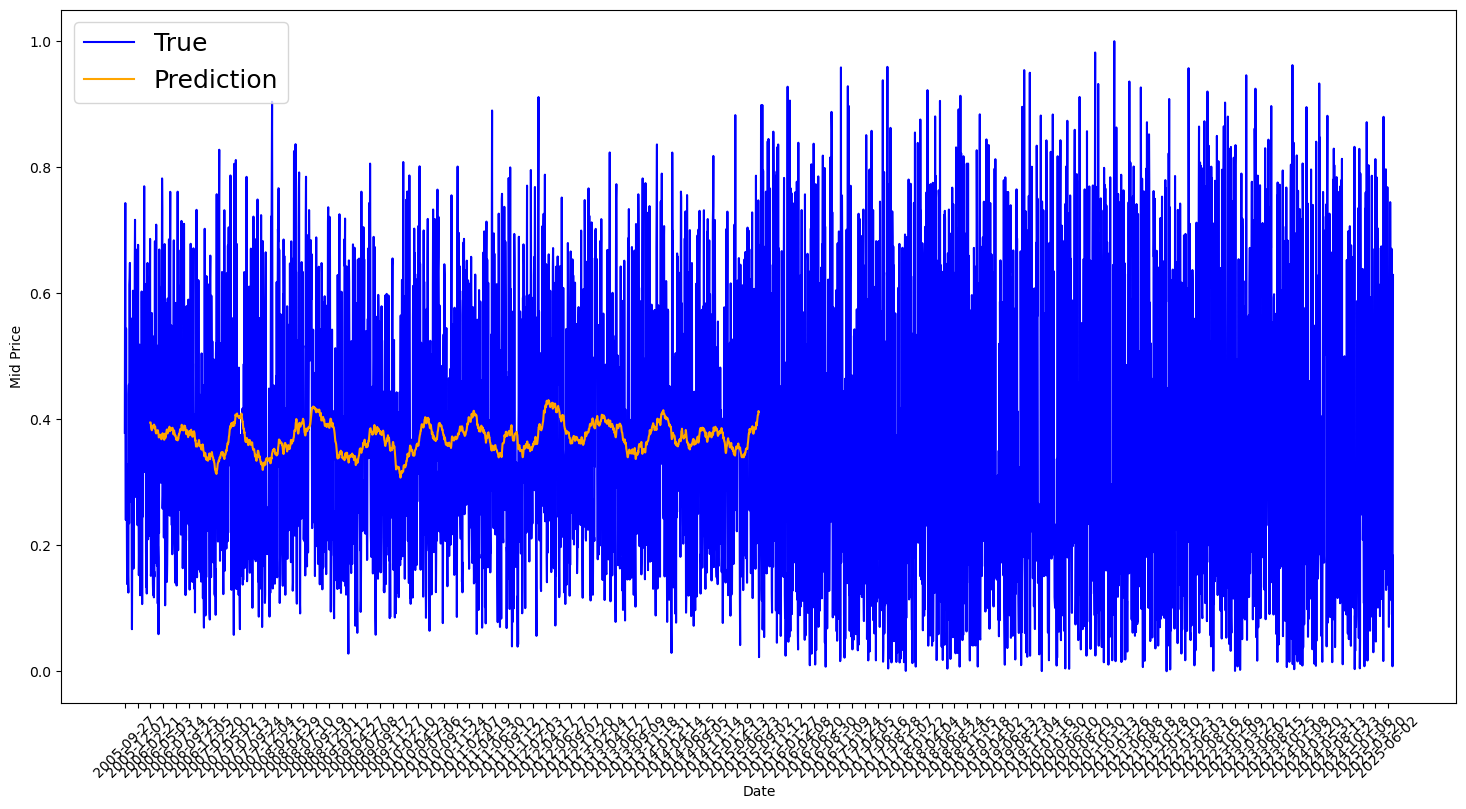

In [79]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [80]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 2000
for di in range(0,10000,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed